### Spatial Model
1. Moran's I Test
2. Spatial Regression

In [10]:
# Import modules

import pandas as pd
import json, requests
import datetime
from datetime import datetime
import io
import os
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from math import sqrt

import pysal as ps
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
from pysal.model import spreg
from splot.esda import plot_moran

import numpy as np
import random
random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
#sns.set(font_scale=2)

In [11]:
## Read in data

# Shape Files
slope_msoa = gpd.read_file('output_data/slope_msoa.shp')

# Shape Files
boroughs = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')

slope_msoa = slope_msoa.to_crs('epsg:27700')
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')

In [12]:
slope_msoa = slope_msoa.rename({'origin_tri':'origin_trips',
                               'destinatio': 'destination_trips',
                               'msoa_decil': 'msoa_decile',
                               'msoa_quint': 'msoa_quintile',
                               'number_tub': 'number_tubestations',
                               'cyclelengt': 'cyclelength_perhect',
                               'coviddeath': 'coviddeaths',
                               'total_inco': 'total_income',
                               'number_edu': 'number_education',
                               'number_bus': 'number_busstops',
                               'number_pub': 'number_pubtrans'}, axis = 1)

slope_msoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   msoa_name            384 non-null    object  
 1   msoa_code            384 non-null    object  
 2   slope                384 non-null    float64 
 3   log_slope            384 non-null    float64 
 4   la_name              384 non-null    object  
 5   la_code              384 non-null    object  
 6   origin_trips         384 non-null    float64 
 7   destination_trips    384 non-null    float64 
 8   imd_score            384 non-null    float64 
 9   msoa_rank            384 non-null    int64   
 10  msoa_decile          384 non-null    int64   
 11  msoa_quintile        384 non-null    int64   
 12  number_tubestations  384 non-null    float64 
 13  cyclelength_perhect  384 non-null    float64 
 14  hw_pct               384 non-null    float64 
 15  coviddeaths    

### Procedure

Still sorting this out, but let's assume:
1. Spatial Exploratory Analysis -- Maps, Boxplots, Scatterplots
2. Validate if there is spatial autocorrelation in the dependent variable
3. If so, build spatial error/lag models in addition to the OLS
4. We need to understand if there is value in a LISA (bottom of the code)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


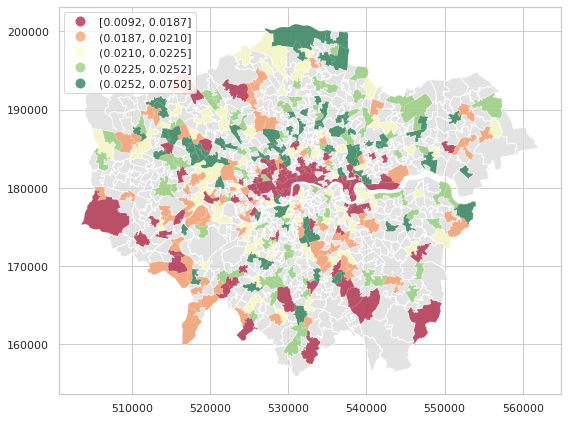

In [13]:
# Plot a chloropeth of slope, code inspired by https://geographicdata.science/book/notebooks/
f, ax = plt.subplots(1, figsize=(9, 9))

df = slope_msoa

plotmsoa = msoas.plot(axes=ax,alpha=0.8,color='gainsboro')
plotdf = df.plot(column='slope', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       legend=True,
                       legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax
                      )

In [14]:
# Fill na for fields that do not have values to allow for OLS model to run

#df = slope_msoa[slope_msoa['slope']<.01]
df['number_education'] = df['number_education'].fillna(0)
df['number_busstops'] = df['number_busstops'].fillna(0)
df['number_pubtrans'] = df['number_pubtrans'].fillna(0)

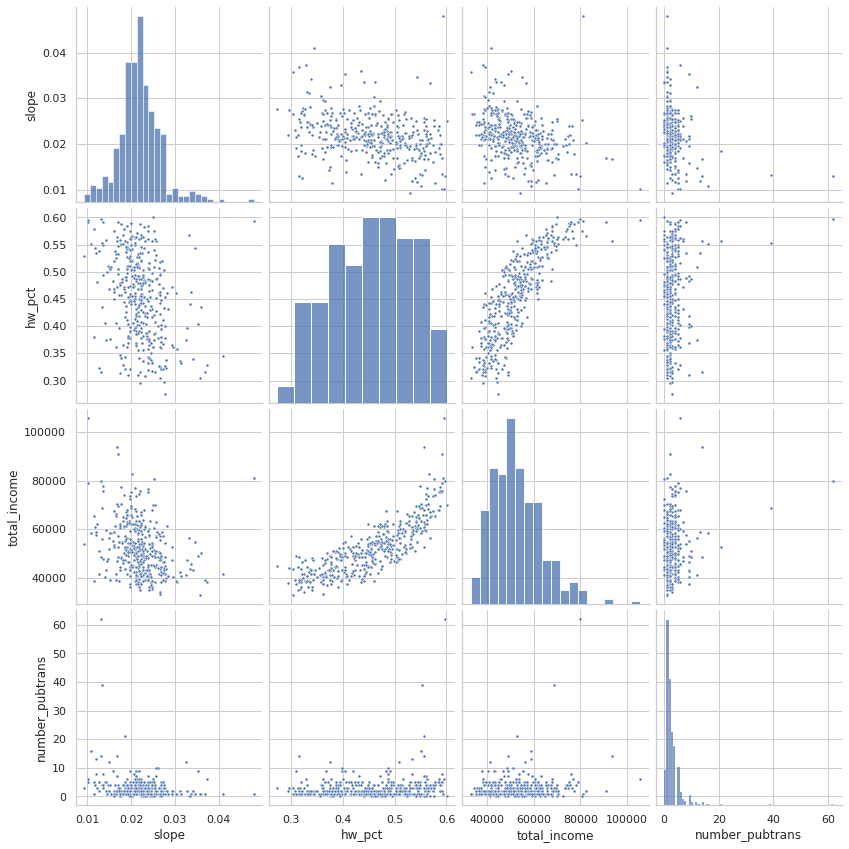

In [15]:
# Pairwise plot to see if there is a linear relationship. Excluding potential outliers (slope > 0.06)

#f, ax = plt.subplots(1, figsize=(20, 20))

df = slope_msoa[slope_msoa['slope']<.06]
#df['log_length'] = np.log(df['length'])

cols_to_plot = ['slope',
                'hw_pct',
                'total_income',
                'number_pubtrans']

sns.pairplot(df, vars=cols_to_plot, markers=".", height=3)

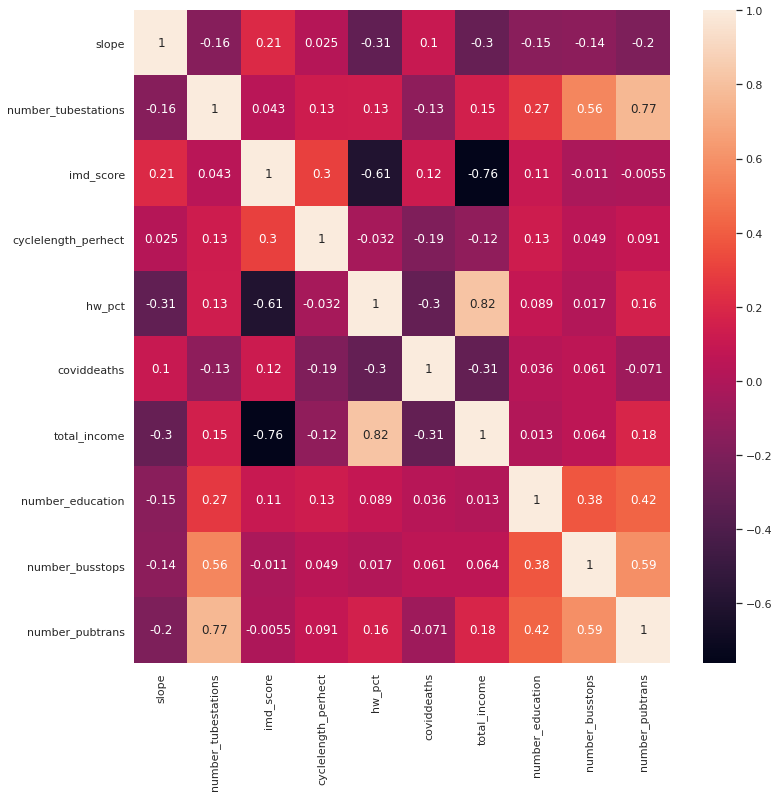

In [16]:
# Correlation Matrix to see which variables have the strongest association with slope

f, ax = plt.subplots(1, figsize=(12, 12))

df = slope_msoa#[slope_msoa['slope']<.06]

df_corr = df[['slope',
              'number_tubestations',
              'imd_score', 
              'cyclelength_perhect',
              'hw_pct',
              'coviddeaths',
              'total_income',
              'number_education',
              'number_busstops',
              'number_pubtrans']]

corrMatrix = df_corr.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [17]:
# Validate Spatial Autocorrelation

In [103]:
# Create a weights matrix for row-standardisation based on distance
df = slope_msoa#[slope_msoa['slope']<.06]
w = weights.distance.KNN.from_dataframe(df, k = 5)
w.transform = 'R'
w

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

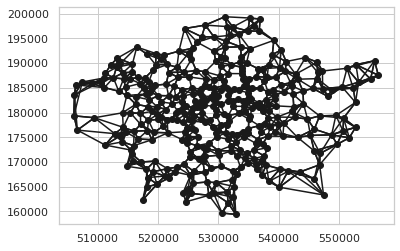

In [104]:
w.plot(df)

In [105]:
# Create a weights matrix based on nearest neighbours
# http://darribas.org/gds15/content/labs/lab_05.html

w_knn = weights.KNN.from_shapefile('output_data/slope_msoa.shp', k = 5)
w_knn.transform = 'R'
w_knn

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

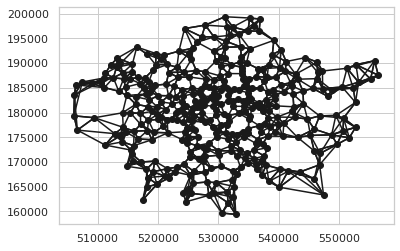

In [106]:
w_knn.plot(df)

In [107]:
# Create a weights matrix based on contiguity
# https://splot.readthedocs.io/en/stable/users/tutorials/weights.html#pysal-spatial-weight-types

qW = weights.Queen.from_shapefile('output_data/slope_msoa.shp')
qW.transform = 'R'
#qW

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING:

/opt/conda/envs/sds2020/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 384 disconnected components.
 There are 384 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

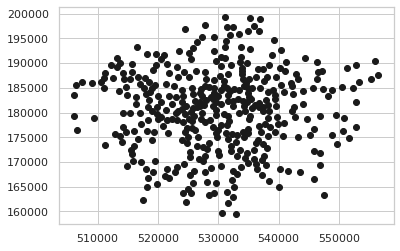

In [108]:
qW.plot(df)

In [109]:
# Calculate Moran's I and significance. Moran's I can range from -1 to 1, showing a weak positive autocorrelation in this case.

df = slope_msoa#[slope_msoa['slope']<.06]

moran = esda.moran.Moran(df['slope'], w)

print(moran.I)
print(moran.p_sim)

0.2074464523158695
0.001


(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.21', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.21)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

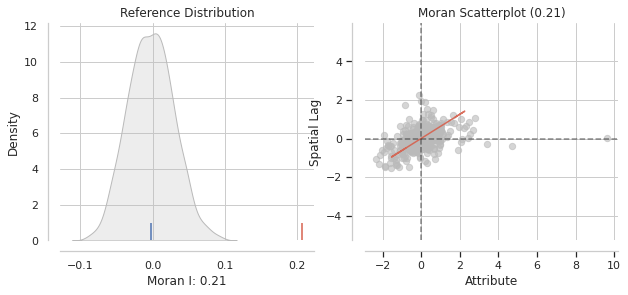

In [110]:
plot_moran(moran)

In [111]:
# Spatial Regression Models: OLS, Spatial Lag, Spatial Error

y = df['slope']

cols = ['hw_pct', 'total_income', 'number_pubtrans']
x = df.loc[:, cols]
#x.values

In [112]:
model = spreg.OLS(y.values[:, None], x.values, w=w, spat_diag = True, moran = True, name_x = cols, name_y = 'slope')
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         384
Mean dependent var  :      0.0221                Number of Variables   :           4
S.D. dependent var  :      0.0055                Degrees of Freedom    :         380
R-squared           :      0.1246
Adjusted R-squared  :      0.1177
Sum squared residual:       0.010                F-statistic           :     18.0302
Sigma-square        :       0.000                Prob(F-statistic)     :   5.846e-11
S.E. of regression  :       0.005                Log likelihood        :    1478.312
Sigma-square ML     :       0.000                Akaike info criterion :   -2948.624
S.E of regression ML:      0.0052                Schwarz criterion     :   -2932.821

-----------------------------------------------------------------------------

In [113]:
# Add spatial weight of slope to dataframe for Spatial Regression Models

#df = slope_msoa

# Assign spatial lag to df
df['w_slope'] = weights.spatial_lag.lag_spatial(w, df['slope'])
df['qW_slope'] = weights.spatial_lag.lag_spatial(qW, df['slope'])
df['knnW_slope'] = weights.spatial_lag.lag_spatial(w_knn, df['slope'])

In [114]:
# See attributes of the spatial weights matrix
#print(w.neighbors)
#print(w.islands)
#print(w.histogram)
#print(w.weights)

In [115]:
# OLS with Spatial Weights in x
cols = ['hw_pct', 'total_income', 'number_pubtrans', 'w_slope']
x = df.loc[:, cols]

model2 = spreg.OLS(y.values[:, None], x.values, w=w, spat_diag = True, moran = True, name_x = cols, name_y = 'slope')
print(model2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         384
Mean dependent var  :      0.0221                Number of Variables   :           5
S.D. dependent var  :      0.0055                Degrees of Freedom    :         379
R-squared           :      0.1764
Adjusted R-squared  :      0.1677
Sum squared residual:       0.010                F-statistic           :     20.2989
Sigma-square        :       0.000                Prob(F-statistic)     :   3.643e-15
S.E. of regression  :       0.005                Log likelihood        :    1490.030
Sigma-square ML     :       0.000                Akaike info criterion :   -2970.061
S.E of regression ML:      0.0050                Schwarz criterion     :   -2950.308

-----------------------------------------------------------------------------

In [116]:
# Spatial Lag model
cols = ['hw_pct', 'total_income', 'number_pubtrans']
x = df.loc[:, cols]

model3 = spreg.GM_Lag(y.values[:, None], x.values, w=w, spat_diag = True, name_x = cols, name_y = 'slope')
print(model3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         384
Mean dependent var  :      0.0221                Number of Variables   :           5
S.D. dependent var  :      0.0055                Degrees of Freedom    :         379
Pseudo R-squared    :      0.1699
Spatial Pseudo R-squared:  0.1471

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.0128468       0.0061079       2.1033137       0.0354384
              hw_pct      -0.0064268       0.0063107      -1.0183949       0.3084903
        total_income      -0.0000000       0.0000000      -

In [117]:
spreg.diagnostics.akaike(model3)

-2964.2135225147035

In [120]:
# Spatial Error Model, treats spatial autocorrelation as a 'nuisance' in the lambda variable.
cols = ['hw_pct', 'total_income', 'number_pubtrans', 'w_slope']
x = df.loc[:, cols]

model4 = spreg.GM_Error_Het(y.values[:, None], x.values, w=w, name_x = cols, name_y = 'slope')
print(model4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         384
Mean dependent var  :      0.0221                Number of Variables   :           5
S.D. dependent var  :      0.0055                Degrees of Freedom    :         379
Pseudo R-squared    :      0.1681
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.0116607       0.0020901       5.5791160       0.0000000
              hw_pct      -0.0047945       0.0047902      -1.0008937       0.31

In [102]:
## Code practice from https://geographicdata.science/book/notebooks/

# Create metrics for a Moran Plot

df = slope_la

# Assign spatial lag to df
df['w_slope'] = weights.spatial_lag.lag_spatial(w, df['slope'])

# standardise the slope and spatial lag to plot
df['slope_std'] = (df['slope']-df['slope'].mean())/df['slope'].std()
df['w_slope_std'] = (df['w_slope']-df['w_slope'].mean())/df['w_slope'].std()

slope_la = df
slope_la.head()

# Code for Moran Plot

df = slope_la

f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(x='slope_std', y='w_slope_std', data=df, ci=None, line_kws={'color':'r'})

# Create quadrants
# Add vertical, horizontal lines at origin and labels
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
plt.text(2, 2, "HH", fontsize=10)
plt.text(2, -2, "HL", fontsize=10)
plt.text(-2, 2, "LH", fontsize=10)
plt.text(-2, -2, "LL", fontsize=10)

# Calculate Moran's I for each datapoint
df = slope_la

lisa = esda.moran.Moran_Local(df['slope'],w)

# add to df, set back to main dataframe
df['Is'] = lisa.Is
slope_la = df

# plot the distribution, which looks somewhat normal
sns.distplot(lisa.Is)


# Spatial plot of lisa
df = slope_la

f, ax = plt.subplots(1, figsize=(9,9))

df.plot(column='Is', cmap='RdYlGn', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
ax.set_axis_off()

# Count the number of datapoints within each quadrant, perhaps if evenly distributed then this is purely random
# 1 = HH, 2 = LH, 3 = LL, 4 = HL
# results show that 23 are in HH/LL, balance in LH/HL.
counts = [(j,(lisa.q == j).sum()) for j in range(1,5)]
print(counts)

# Furthermore, we'll assign each value to a cluster based on its significance of autocorrelation
df = slope_la

sig = 1*(lisa.p_sim < 0.05) # binary to indicate which local authorities are significant
df['p-sim'] = lisa.p_sim
df['sig'] = sig
slope_la = df
df[['la_name','sig', 'p-sim']].head()


# Now we label the data with not-significant, hh, ll, hl, lh. 
df = slope_la

hh = 1*(sig*lisa.q==1)
ll = 3*(sig*lisa.q==3)
lh = 2*(sig*lisa.q==2)
hl = 4*(sig*lisa.q==4)
spots = hh + ll + lh + hl
spot_labels = ['0 ns', '1 hh', '2 lh', '3 ll', '4 hl']
labels = [spot_labels[i] for i in spots]
df['labels'] = labels

slope_la = df
[(spot_label, (df['labels']==spot_label).sum()) for spot_label in spot_labels]



# Plot labels based on significance
# Based on this, we can visually see that it is central and west london that appear to be in the ll quadrant significantly, only Redbridge in the hh quadrant is significant.
# Based on the Moran plot, those that are negative are statistically significantly below the mean standardised slope of all local authorities.
df = slope_la

f, ax = plt.subplots(1, figsize=(9,9))
hmap = colors.ListedColormap(['lightgrey', 'green', 'lightgreen', 'orange'])
df.plot(column='labels', categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax,
        edgecolor='white', legend=True)
ax.set_axis_off()

NameError: name 'slope_la' is not defined